# Team Assignment 1 - Isa's Data (Rural Elecricity, Mobile Subscriptions, Broadband Access)

In [88]:
#Necessary Importations
import pandas as pd
import requests
import io
import os
import seaborn as sns
import matplotlib.pyplot as plt 

# Functions & Variables to be used

In [89]:
asean_list = ['VNM','LAO','THA','KHM','MYS','SGP','MMR','PHL','BRN','IDN']
south_asia_list = ['BGD','IND','PAK','NPL','LKA','BTN']

def download_worldbank(indicator, countries, date_start, date_end):
    url_base = 'http://api.worldbank.org/v2/'  # Base URL for the World Bank API
    country_codes = ';'.join(countries)  # Combine country codes into a string
    url = url_base + f'country/{country_codes}/indicator/{indicator}?date={date_start}:{date_end}&per_page=30000' #create the url with start and end date.
    url = url_base + f'country/{country_codes}/indicator/{indicator}?per_page=30000' # This line overrides the previous one. It will ignore start/end date.

    response = requests.get(url)  # Download data from the URL
    df = pd.read_xml(response.content)  # Convert the downloaded data to a table
    return df  # Return the table

def clean_wb(data):
    data = data.drop(["country","unit","decimal","obs_status","indicator"], axis=1)
    data = data.rename({"countryiso3code":'country',"date":'year'}, axis=1)
    return data

def change_date(data):
    data.year = pd.PeriodIndex(data.year, freq = 'Q').to_timestamp()
    return data

# Download Datasets

In [90]:
# INDICATORS
re = 'EG.ELC.ACCS.RU.ZS'
cs = 'IT.CEL.SETS.P2'
bs = 'IT.NET.BBND.P2'

# ASEAN VARIABLES
df_re_asean = None
df_cs_asean = None
df_bs_asean = None

#SOUTH ASIA VARIABLES
df_re_sa = None
df_cs_sa = None
df_bs_sa = None

indicators = [re, cs, bs]
asean_variables = ['df_re_asean', 'df_cs_asean', 'df_bs_asean']
sa_variables = ['df_re_sa','df_cs_sa','df_bs_sa']

for i, x in enumerate(indicators):
    locals()[asean_variables[i]] = download_worldbank(
        indicator=x,
        countries=asean_list,
        date_start='2011',
        date_end='2024',
    )

for i, x in enumerate(indicators):
    locals()[sa_variables[i]] = download_worldbank(
        indicator=x,
        countries=south_asia_list,
        date_start='2011',
        date_end='2024',
    )


# Cleaning the Datasets

In [91]:
df_re_asean.head(2)

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"Access to electricity, rural (% of rural popul...",Brunei Darussalam,BRN,2024,NaN,NaN,NaN,1
1,"Access to electricity, rural (% of rural popul...",Brunei Darussalam,BRN,2023,100.0,NaN,NaN,1


In [92]:
df_re_asean = clean_wb(df_re_asean)
df_re_asean = df_re_asean.rename({'value':"Rural Access to Electricity(Percent of Population)"},axis=1)

df_cs_asean = clean_wb(df_cs_asean)
df_cs_asean = df_cs_asean.rename({'value':"Mobile Cellular Subscriptions (per 100 people)"},axis=1)

df_bs_asean = clean_wb(df_bs_asean)
df_bs_asean = df_bs_asean.rename({'value':"Fixed Broadband Subsciptions (per 100 people)"},axis=1)

df_re_sa = clean_wb(df_re_sa)
df_re_sa = df_re_sa.rename({'value':"Rural Access to Electricity(Percent of Population)"},axis=1)

df_cs_sa = clean_wb(df_cs_sa)
df_cs_sa = df_cs_sa.rename({'value':"Mobile Cellular Subscriptions (per 100 people)"},axis=1)

df_bs_sa = clean_wb(df_bs_sa)
df_bs_sa = df_bs_sa.rename({'value':"Fixed Broadband Subsciptions (per 100 people)"},axis=1)

df_re_asean.head()

,country,year,Rural Access to Electricity(Percent of Population)
0,BRN,2024,NaN
1,BRN,2023,100.0
2,BRN,2022,100.0
3,BRN,2021,100.0
4,BRN,2020,100.0


In [93]:
datasets = {
    'df_re_asean': df_re_asean,
    'df_cs_asean': df_cs_asean,
    'df_bs_asean': df_bs_asean,
    'df_re_sa': df_re_sa,
    'df_cs_sa': df_cs_sa,
    'df_bs_sa': df_bs_sa
}

for name, dataset in datasets.items():
    datasets[name] = change_date(dataset)

df_re_asean, df_cs_asean, df_bs_asean, df_re_sa, df_cs_sa, df_bs_sa = datasets.values()

In [94]:
for name, dataset in datasets.items():
    datasets[name] = dataset.set_index(['country','year'])

df_re_asean, df_cs_asean, df_bs_asean, df_re_sa, df_cs_sa, df_bs_sa = datasets.values()

# Merging the Datasets

In [95]:
asean_merged = pd.merge(
    df_re_asean,
    df_cs_asean,
    right_index=True,
    left_index=True,
    how='inner'
)

asean_merged = pd.merge(
    asean_merged,
    df_bs_asean,
    right_index=True,
    left_index=True,
    how='inner'
)

In [96]:
asean_merged.head()

Rural Access to Electricity(Percent of Population)  \
country year                                                             
BRN     2024-01-01                                                NaN    
        2023-01-01                                              100.0    
        2022-01-01                                              100.0    
        2021-01-01                                              100.0    
        2020-01-01                                              100.0    

                    Mobile Cellular Subscriptions (per 100 people)  \
country year                                                         
BRN     2024-01-01                                             NaN   
        2023-01-01                                             NaN   
        2022-01-01                                      117.755155   
        2021-01-01                                      135.501254   
        2020-01-01                                      121.475805   

                    Fixed Broadband Subsciptions (per 100 people)  
country year                                                       
BRN     2024-01-01                                            NaN  
        2023-01-01                                        20.2120  
        2022-01-01                                        19.8050  
        2021-01-01                                        17.5810  
        2020-01-01                                        15.8868

In [97]:
sa_merged = pd.merge(
    df_re_sa,
    df_cs_sa,
    right_index=True,
    left_index=True,
    how='inner'
)

sa_merged = pd.merge(
    sa_merged,
    df_bs_sa,
    right_index=True,
    left_index=True,
    how='inner'
)

In [98]:
sa_merged.head()

Rural Access to Electricity(Percent of Population)  \
country year                                                             
BGD     2024-01-01                                                NaN    
        2023-01-01                                               99.6    
        2022-01-01                                               99.2    
        2021-01-01                                               98.5    
        2020-01-01                                               95.2    

                    Mobile Cellular Subscriptions (per 100 people)  \
country year                                                         
BGD     2024-01-01                                             NaN   
        2023-01-01                                             NaN   
        2022-01-01                                      105.264249   
        2021-01-01                                      108.909443   
        2020-01-01                                      105.291163   

                    Fixed Broadband Subsciptions (per 100 people)  
country year                                                       
BGD     2024-01-01                                            NaN  
        2023-01-01                                        7.51447  
        2022-01-01                                        7.17020  
        2021-01-01                                        6.64247  
        2020-01-01                                        6.04506

In [99]:
asean_merged.describe()

,Rural Access to Electricity(Percent of Population),Mobile Cellular Subscriptions (per 100 people),Fixed Broadband Subsciptions (per 100 people)
count,285.000000,503.000000,219.000000
mean,78.874865,39.464250,6.024162
std,27.674043,55.498515,7.826552
min,0.600000,0.000000,0.000389
25%,62.800000,0.000000,0.249315
50%,93.400000,1.077223,2.427400
75%,100.000000,85.797602,8.574110
max,100.000000,181.767026,28.539300


In [100]:
sa_merged.describe()

,Rural Access to Electricity(Percent of Population),Mobile Cellular Subscriptions (per 100 people),Fixed Broadband Subsciptions (per 100 people)
count,161.000000,305.000000,114.000000
mean,64.983029,25.005191,1.879223
std,28.084299,40.022626,2.300688
min,2.238845,0.000000,0.001668
25%,44.406868,0.000000,0.305951
50%,70.900000,0.022781,1.090730
75%,88.900000,49.621519,2.306780
max,100.000000,143.079417,10.540100


# Preliminary Visualizations

Text(0.5, 1.0, 'South Asia Rural Electricity Access over Time')

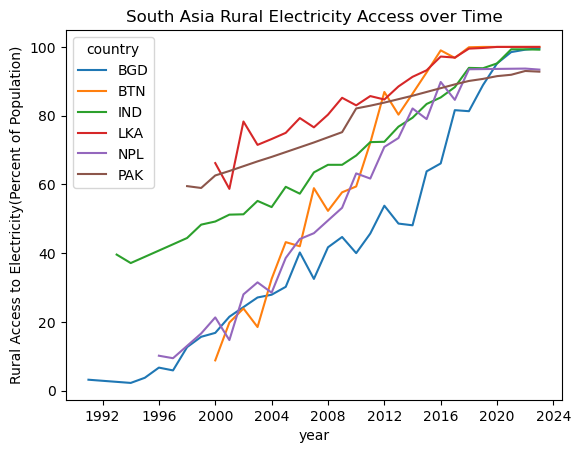

In [103]:
sns.lineplot(
    data = sa_merged,      # Dataframe with long format data
    x = 'year',                   # Column for x-axis (dates)
    y = 'Rural Access to Electricity(Percent of Population)',         # Column for y-axis (GDP values)
    hue = 'country'               # Column for color differentiation (countries)
).set_title("South Asia Rural Electricity Access over Time")

Text(0.5, 1.0, 'ASEAN Rural Electricity Access over Time')

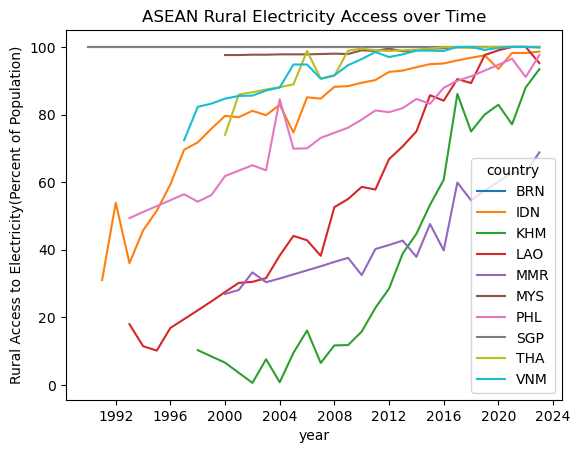

In [104]:
sns.lineplot(
    data = asean_merged,      # Dataframe with long format data
    x = 'year',                   # Column for x-axis (dates)
    y = 'Rural Access to Electricity(Percent of Population)',         # Column for y-axis (GDP values)
    hue = 'country'               # Column for color differentiation (countries)
).set_title("ASEAN Rural Electricity Access over Time")